In [1]:
# Import modules
import borg
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial
from scipy.stats import nbinom
import spatial_stats
from numpy.random import default_rng


[0 / 1] [INFO   ] libLSS version 104695894414317dee94bda1afded8ba7c342653 built-in modules Initializing console.

[0 / 1] [STD    ] Using OneAPI/TBB (default scheduler).
[0 / 1] [INFO S ] Registered likelihoods:
[0 / 1] [INFO S ]    BORG_NULL, BORG_POISSON, BORG_REDUCED_SHEAR, BORG_SHEAR, BORG_STUDENT_T
[0 / 1] [INFO S ]    EFT_BIAS_LIKE, EFT_BIAS_MARG_LIKE, GAUSSIAN_BROKEN_POWER_LAW_BIAS, GAUSSIAN_LINEAR_BIAS
[0 / 1] [INFO S ]    GAUSSIAN_MO_WHITE_BIAS, GAUSSIAN_POWER_LAW_BIAS, GENERIC_GAUSSIAN_MANY_POWER_1^1
[0 / 1] [INFO S ]    GENERIC_GAUSSIAN_MANY_POWER_1^2, GENERIC_POISSON_BROKEN_POWERLAW_BIAS
[0 / 1] [INFO S ]    GENERIC_POISSON_BROKEN_POWERLAW_SIGMOID_BIAS, GENERIC_POISSON_MANY_POWER_1^1
[0 / 1] [INFO S ]    GENERIC_POISSON_MANY_POWER_1^2, GENERIC_POISSON_MANY_POWER_1^2_DEGRADE4
[0 / 1] [INFO S ]    GENERIC_POISSON_MANY_POWER_2^2, GENERIC_POISSON_MANY_POWER_2^2_DEGRADE4
[0 / 1] [INFO S ]    GENERIC_POISSON_MO_WHITE_BIAS, GENERIC_POISSON_POWERLAW_BIAS, GENERIC_POISSON_POWERLAW_B

In [2]:
# Define the Poisson distribution function
def f_P(lam, N):
    x = np.exp(-lam) * (lam**N) /factorial(N)
    return x


# Define the negative binomial distribution function
def f_NB(lam, N, r):
    x =(lam**N) / factorial(N) * gamma(r + N) / (gamma(r) * (r + lam)**N) * (1 / (1 + lam / r))**r
    return x

# Define the generalized trinomial distribution function
def f_SH(lam, N, b):
    x = lam / factorial(N) * np.exp(-lam * (1 - b) - b * N) * (1 - b) * (lam * (1 - b) + b * N)**(N - 1)
    return x

In [3]:
x = np.linspace(0.,100,101)

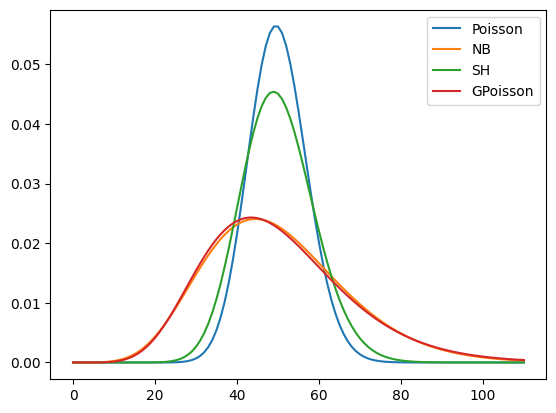

In [18]:
lam = 50
r = 0.6
plt.plot (x,f_P(lam,x),label="Poisson")
plt.plot (x,f_NB(lam,x,10),label="NB")
plt.plot (x,f_SH(lam,x,0.2),label="SH")
plt.plot (x,gpd(x, theta=lam*(1-r),lambd=r),label="GPoisson")
plt.legend()

In [13]:
box = borg.forward.BoxModel()
box.L = (1000,1000,1000)
box.N = (256,256,256)

# Generate gaussian random numbers, Fourier transform them, and rescale to ensure unit-variance
np.random.seed(10)
ic = np.fft.rfftn(np.random.randn(*box.N))/box.Ntot**(0.5)

#define chain

chain = borg.forward.ChainForwardModel(box)
chain.addModel(borg.forward.models.HermiticEnforcer(box))
chain.addModel(borg.forward.models.Primordial(box, 0.1))
chain.addModel(borg.forward.models.EisensteinHu(box))
lpt = borg.forward.models.BorgLpt(box=box, box_out=box, ai=0.1, af=1.0, supersampling=2)
chain.addModel(lpt)
cosmo_par = borg.cosmo.CosmologicalParameters()
cosmo_par.default()
chain.setCosmoParams(cosmo_par)
chain.forwardModel_v2(ic)
rho_truth = np.empty(chain.getOutputBoxModel().N)
chain.getDensityFinal(rho_truth)

/var/folders/rl/c25yp6m1343384wd257_w0z40000gn/T/ipykernel_75012/3141494185.py:14: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/var/folders/rl/c25yp6m1343384wd257_w0z40000gn/T/ipykernel_75012/3141494185.py:15: DeprecationWarning: Call to deprecated class BorgLpt. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  lpt = borg.forward.models.BorgLpt(box=box, box_out=box, ai=0.1, af=1.0, supersampling=2)


[STD    ] |     ___________                              
[STD    ] |    /-/_"/-/_/-/|     __________________________ 
[STD    ] |   /"-/-_"/-_//||                BORG3 model
[STD    ] |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] |  |-+-|.|_'-"||//     __________________________ 
[STD    ] |  |[".[:!+-'=|//     
[STD    ] |  |='!+|-:]|-|/       
[STD    ] |   ----------         
[STD    ] | 
[STD    ] | Please acknowledge the following papers:
[STD    ] |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] |   - Lavaux, Jasche & Leclercq (arXiV 1909.06396)
[STD    ] |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | 

[STD    ] | This is BORG version 104695894414317dee94bda1afded8ba7c342653


In [68]:
n_mean = 1
lam = n_mean * (1 + rho_truth) ** 1.2
#ngal_p = np.random.poisson(lam)
r = 0.6
#ngal_nb =  nbinom.rvs (r,1/(lam/r +1))
ngal_gp = gen_gpd_field(lam,r)

Text(0.5, 1.0, 'GP')

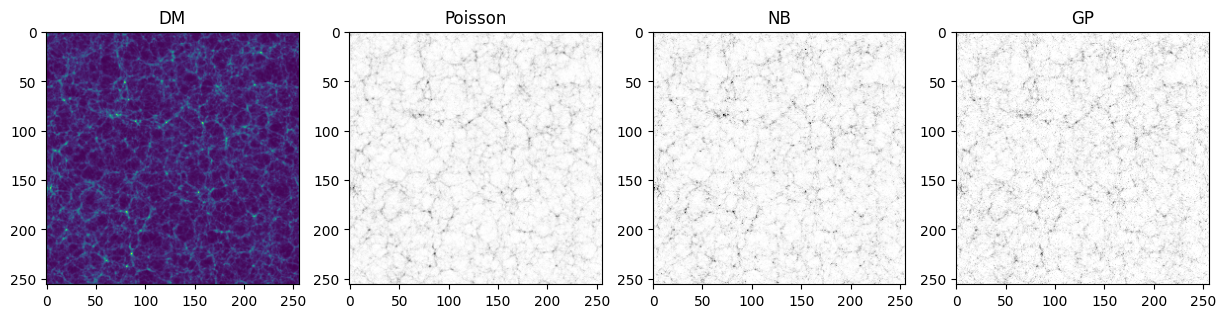

In [69]:
fig,ax =plt.subplots(ncols=4,figsize=(15,5)) 
ax[0].imshow(rho_truth[:,:,0:10].mean(-1))
ax[0].set_title("DM")
im1 = ax[1].imshow(ngal_p[:,:,0:10].mean(-1),vmax = 20, cmap="gray_r")
ax[1].set_title("Poisson")
im2 = ax[2].imshow(ngal_nb[:,:,0:10].mean(-1),vmax = 20, cmap="gray_r")
ax[2].set_title("NB")
im3 = ax[3].imshow(ngal_gp[:,:,0:10].mean(-1),vmax = 20, cmap="gray_r")
ax[3].set_title("GP")


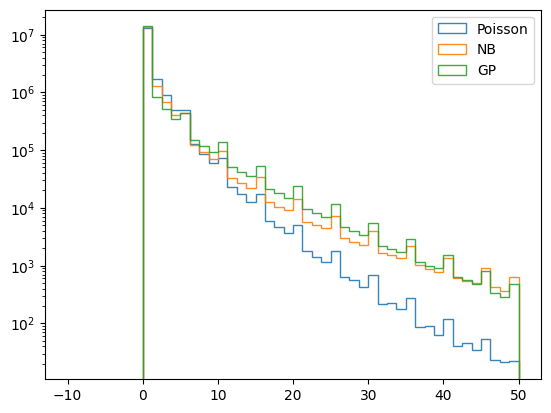

In [70]:
bins=np.linspace(-10,50,49)
_ = plt.hist(ngal_p.flatten(),bins=bins,label="Poisson",alpha=0.9,histtype="step")
_ = plt.hist(ngal_nb.flatten(),bins=bins,label="NB",alpha=0.9,histtype="step")
_ = plt.hist(ngal_gp.flatten(),bins=bins,label="GP",alpha=0.9,histtype="step")

plt.semilogy()
plt.legend()

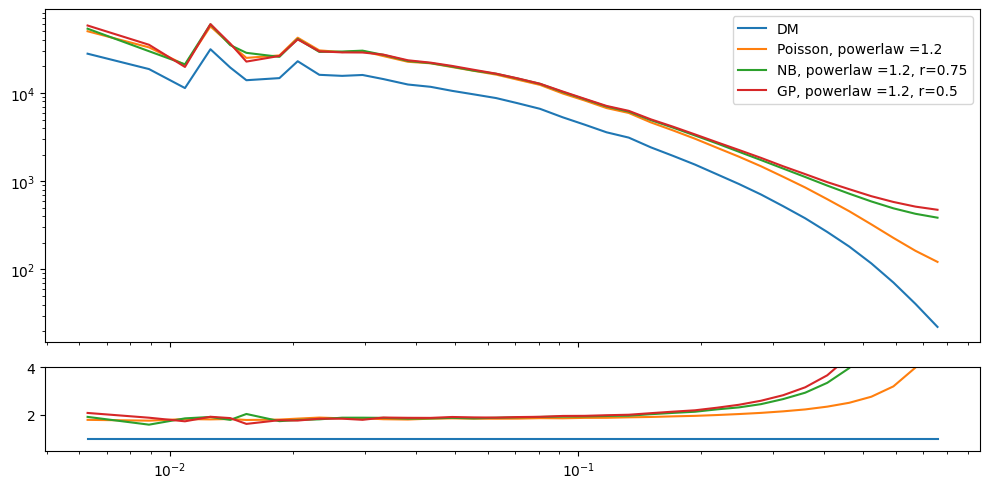

In [71]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,5), gridspec_kw={'height_ratios': [4, 1]})

k1,pk1 = spatial_stats.getPk(rho_truth,boxsize=box.L[0])
k2,pk2 = spatial_stats.getPk(ngal_p,boxsize=box.L[0])
k3,pk3 = spatial_stats.getPk(ngal_nb,boxsize=box.L[0])
k4,pk4 = spatial_stats.getPk(ngal_gp,boxsize=box.L[0])

ax[0].loglog(k1,pk1,label="DM")
ax[0].loglog(k2,pk2,label="Poisson, powerlaw =1.2")
ax[0].loglog(k3,pk3,label="NB, powerlaw =1.2, r=0.75")
ax[0].loglog(k4,pk4,label="GP, powerlaw =1.2, r=0.5")

ax[0].legend()
ax[1].plot(k1,pk1/pk1,label="DM")
ax[1].plot(k2,pk2/pk1,label="Poisson, powerlaw =1.1")
ax[1].plot(k3,pk3/pk1,label="NB, powerlaw =1.1, r=20")
ax[1].plot(k4,pk4/pk1,label="NB, powerlaw =1.1, r=20")

ax[1].set_ylim(0.5,4)

plt.tight_layout()

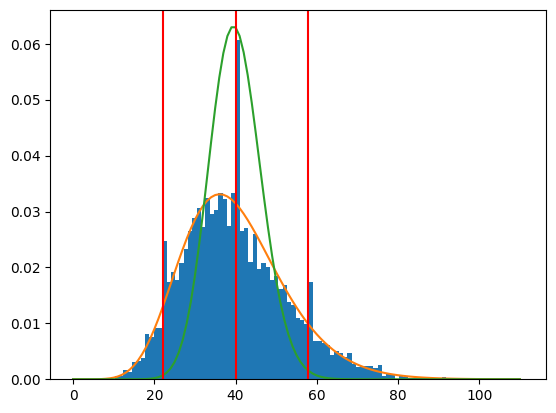

In [6]:
def gen_gpd(theta, lambd, n):
    myset = np.zeros(n)
    w = np.exp(-lambd)
    rng = default_rng()
    for i in range(n):
        mys = np.exp(-theta)
        myp = mys
        x = 0
        u = rng.uniform(0, 1)
        while u > mys:
            x += 1
            myc = theta - lambd + lambd*x
            myp = w * myc * (1 + lambd / myc) ** (x-1) * myp * x ** (-1)
            mys += myp
        myset[i] = x
    return myset
def gpd(x, theta=0.4,lambd=0.75):
    fact = factorial(x)
    return theta*(theta+lambd*x)**(x*1.0-1)* np.exp(-(theta+lambd*x))/fact
def mean_gpd(theta=0.4,lambd=0.75):
    return theta/(1-lambd)
def var_gpd(theta=0.4,lambd=0.75):
    return theta/(1-lambd)**3
theta=40
lambd=0.5
r = gen_gpd(theta*(1-lambd), lambd, 10000)
x = np.arange(np.max(r))
y0 = gpd(x, theta=theta*(1-lambd),lambd=lambd)
y1 = gpd(x, theta=theta,lambd=0)
mu_gpd = mean_gpd(theta=theta,lambd=lambd)*(1-lambd)
std_gpd = np.sqrt(var_gpd(theta=theta,lambd=lambd))
plt.hist(r,bins=100,density=True)
plt.plot(x,y0)
plt.plot(x,y1)
plt.axvline(x=mu_gpd,color='red')
plt.axvline(x=mu_gpd-std_gpd,color='red')
plt.axvline(x=mu_gpd+std_gpd,color='red')
plt.show()



In [5]:
def gen_gpd_field(poisson_int, r):
    aux = poisson_int.flatten()
    mu  = aux*(1-r+1E-4)
    for i in np.arange(len(aux)):
        aux[i] = gen_gpd(mu[i], r, 1)
    return aux.reshape(np.shape(poisson_int))